In [ ]:
#libraries installed
pip install qiskit qiskit-aer pillow opencv-python pylatexenc tensorflow numpy pandas matplotlib h5py

In [1]:
import qiskit
print(qiskit.__version__)


1.0.2


In [2]:
# QML
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
#import cv2
from sklearn.model_selection import train_test_split

# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
import numpy as np

#Simulation
from qiskit_aer import AerSimulator
from qiskit import transpile

#Parallel Processing
import concurrent.futures

#cv2
import cv2

from qiskit.visualization import plot_histogram

#Math
import math


In [3]:
data_train = []
type_of_disease =['Benign cases_Reduced', 'Malignant cases_Reduced','Normal cases_Reduced']
data_directory = r'C:\Users\phala\Downloads\QCNNDataset'
train_directory = os.path.join(data_directory)
for id, sp in enumerate(type_of_disease):
    for file in os.listdir(os.path.join(train_directory, sp)):
        data_train.append(['{}/{}/{}'.format(data_directory,sp, file), id, sp])
        
train = pd.DataFrame(data_train, columns=['Image', 'Id of Disease','Type of Disease'])

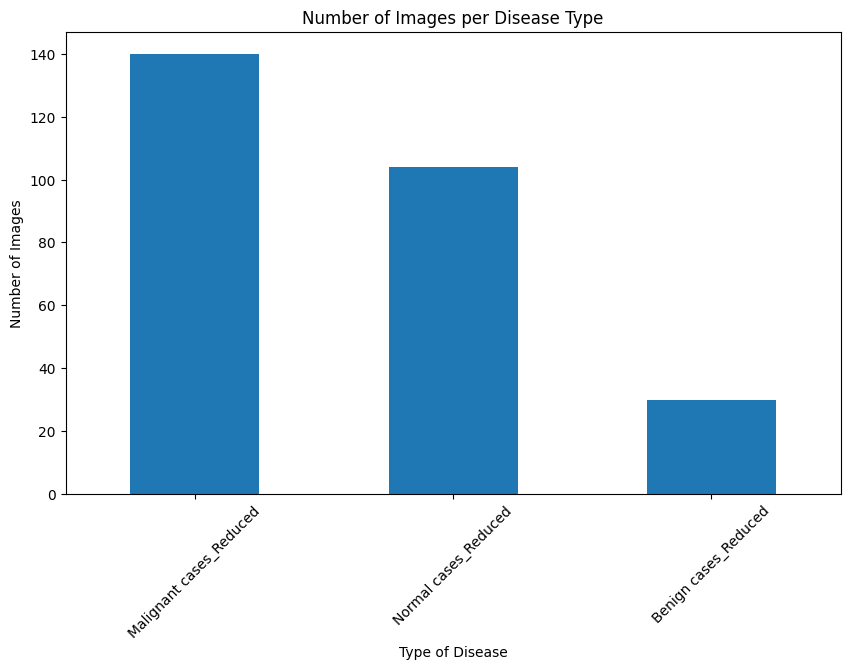

In [4]:
# Plotting the bar chart
counts = train['Type of Disease'].value_counts()
plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.title('Number of Images per Disease Type')
plt.xlabel('Type of Disease')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [5]:
#make the order of training set randomize
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))


In [6]:
print (train.shape)


(274, 3)


**In the following cell, we show the implementation of dynamic filter 1. Likewise, we can also show the implementation of dynamic filter 2, 3 and 4.**

In [7]:
def CONVCircuit(phi):
    qc=QuantumCircuit(4,4)
    # parameter
    theta = np.pi / 2
   
    #encoding classical data to quantum data
    qc.rx(phi[0] * np.pi, 0)
    qc.rx(phi[1] * np.pi, 1)
    qc.rx(phi[2] * np.pi, 2)
    qc.rx(phi[3] * np.pi, 3)

    #LEARNABLE QUANTUM CIRCUIT

    # with qc.for_loop(range(2)) as _:
    #     qc.crz(theta, 1, 0)
    #     qc.crz(theta, 3, 2)

    qc.crz(theta, 1, 0)
    qc.crz(theta, 3, 2)
    qc.crx(theta, 1, 0)
    qc.crx(theta, 3, 2)
    
    with qc.for_loop(range(2)) as _:
         qc.crz(theta, 2, 0)
         qc.crx(theta, 2, 0)
   
    #measure and run circuit    
    qc.measure([0],[0])
    backend = AerSimulator()
    new_circuit = transpile(qc, backend)
    job = backend.run(qc.decompose(reps=6))
    result = job.result()
    counts = result.get_counts(qc)

    # Extract the expectation value (average of Z measurement outcomes)
    expectation_value = (counts.get('0000', 0) - counts.get('0001', 0)) / 1024

    return [qc,expectation_value]

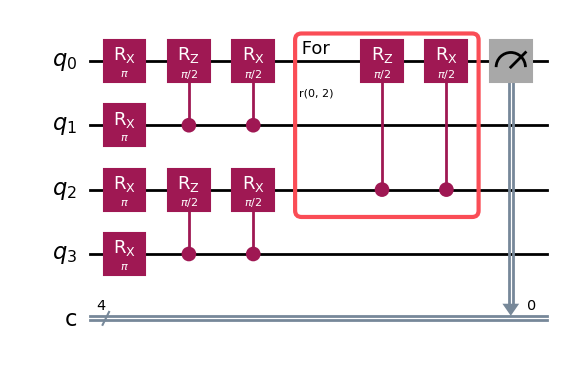

In [8]:
phi = [1, 1, 1, 1]
n = 4
qc= CONVCircuit(phi)[0]
qc.draw("mpl")

In [9]:
expectation_val=CONVCircuit(phi)[1]
print (expectation_val)

-0.486328125


In [10]:
def QCONV1(X, image_number, image_total, step=2):
    H, W = X.shape
    step2 = 2
    out = np.zeros(((H//step), (W//step)))
    for i in range(0, W, step):
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # get 2x2 pixels and make them 1D array
            phi = X[i:i+2, j:j+2].flatten()
            if len(phi) == 0:
              continue  # Skip this iteration if phi is empty
            if len(phi) < 3:
            # print(f"Skipping processing for {file} due to insufficient phi size.")
              continue  # Skip this iteration if phi does not meet size requirements
            measurement = CONVCircuit(phi)[1]
            out[i//step, j//step] = measurement

    return out

**In the following cell, we process the images that are stored in our local device. So, we have interrupted the kernel to avoid duplicate files.**

In [11]:
processFolder = r'C:\Users\phala\Downloads\QCNNDataset\Processed'

# Parameters for processing
scale_percent = 25  # percent of original size for resizing
step = 2  # Step for the QCONV1 function

# Ensure the processed directory exists
if not os.path.exists(processFolder):
    os.makedirs(processFolder)
print('task _ completed')
start = timer()


for id, sp in enumerate(type_of_disease):
    print(f"Processing {sp}...")
    for file in os.listdir(os.path.join(train_directory, sp)):
        filepath = os.path.join(train_directory, sp, file)
        processed_filepath = os.path.join(processFolder, sp, file.split('.')[0] + '.npz')

        # Check if already processed
        if os.path.exists(processed_filepath):
            continue

        # Read image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if the file is not an image

        # Resize image
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

        # Normalize
        NorImages = resized / 255.0
        
        # Apply Quantum Convolution
        processed = QCONV1(NorImages, file, len(os.listdir(os.path.join(train_directory, sp))), step)
        
        # Ensure the disease type subfolder exists in the processed folder
        processed_subfolder = os.path.join(processFolder, sp)
        if not os.path.exists(processed_subfolder):
            os.makedirs(processed_subfolder)

        # Save processed image and label
        np.savez_compressed(processed_filepath, image=processed, label=id)

end = timer()
time = (end - start)
print("Processing completed in:", str(timedelta(seconds=round(time))))

task _ completed
Processing Benign cases_Reduced...


KeyboardInterrupt: 

In [12]:
for id, sp in enumerate(type_of_disease):
    for file in os.listdir(os.path.join(train_directory, sp)):
        filepath = os.path.join(train_directory, sp, file)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        # Check if the image is empty or could not be read
        if img is None or img.size == 0:
            print(f"Empty or unreadable image: {file} in {sp}")
            continue

        # Assuming resizing logic is here
        # resized = ...

        # Check after resizing and normalizing
        if resized.size == 0 or np.any(resized.shape == 0):
            print(f"Image becomes empty after resizing: {file} in {sp}")
            continue

        # Proceed with further processing...

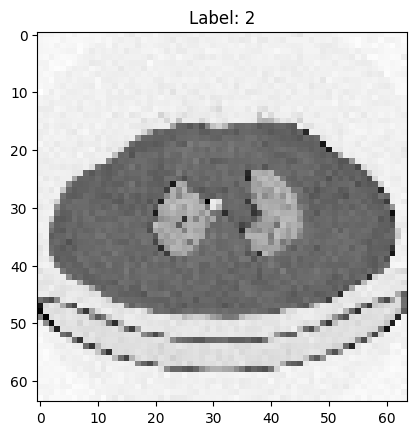

In [13]:
data_directory = r'C:\Users\phala\Downloads\QCNNDataset\Phalak_Circuit3_Processed\Mixed_Reduced'
filename = 'Normal case (360).npz'  # Example filename, adjust as necessary

file_path = os.path.join(data_directory, filename)

# Check if the file exists
if os.path.exists(file_path):
    data = np.load(file_path)
    image = data['image.npy']  # Adjusted key to match your description
    label = data['label.npy']  # Adjusted key to match your description

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.show()
else:
    print(f'File does not exist: {file_path}')

In [14]:
image.shape

(64, 64)

In [15]:
data = np.load(file_path)
print(list(data.keys()))  # This will print all keys in the .npz file


['image', 'label']


In [16]:
processed_folder = r'C:\Users\phala\Downloads\QCNNDataset\Phalak_Circuit3_Processed\Mixed_Reduced'
data = []

# Collect data
for subdir, dirs, files in os.walk(processed_folder):
    for file in files:
        if file.endswith('.npz'):
            file_path = os.path.join(subdir, file)
            with np.load(file_path) as data_file:
                image = data_file['image']
                label = data_file['label']
                label = label
                print(file)
                print(label)
                data.append((image, label))


Bengin case (100).npz
0
Bengin case (101).npz
0
Bengin case (102).npz
0
Bengin case (103).npz
0
Bengin case (104).npz
0
Bengin case (105).npz
0
Bengin case (106).npz
0
Bengin case (107).npz
0
Bengin case (108).npz
0
Bengin case (109).npz
0
Bengin case (110).npz
0
Bengin case (111).npz
0
Bengin case (112).npz
0
Bengin case (113).npz
0
Bengin case (114).npz
0
Bengin case (115).npz
0
Bengin case (116).npz
0
Bengin case (117).npz
0
Bengin case (118).npz
0
Bengin case (119).npz
0
Bengin case (120).npz
0
Bengin case (91).npz
0
Bengin case (92).npz
0
Bengin case (93).npz
0
Bengin case (94).npz
0
Bengin case (95).npz
0
Bengin case (96).npz
0
Bengin case (97).npz
0
Bengin case (98).npz
0
Bengin case (99).npz
0
Malignant case (422).npz
1
Malignant case (423).npz
1
Malignant case (424).npz
1
Malignant case (425).npz
1
Malignant case (426).npz
1
Malignant case (427).npz
1
Malignant case (428).npz
1
Malignant case (429).npz
1
Malignant case (430).npz
1
Malignant case (431).npz
1
Malignant case (432

In [17]:
with np.load(file_path) as data_file:
    print(data_file['label'])


2


In [18]:
np.random.seed(50)  # You can use any number here
np.random.shuffle(data)


In [19]:
X, y = zip(*data)  # This creates separate lists for images and labels

# Convert lists to NumPy arrays if necessary
X = np.array(X, dtype=object)  # Using dtype=object for arrays of varying shapes
y = np.array(y)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.60, random_state=20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=20)

In [20]:
X.shape, y.shape


((274,), (274,))

In [21]:
print("Unique classes in y_test:", np.unique(y))


Unique classes in y_test: [0 1 2]


In [22]:
print(X_train.size)

109


In [23]:
X_train.shape, X_test.shape, X_val.shape, y_val.shape, y_train.shape, y_test.shape

((109,), (66,), (99,), (99,), (109,), (66,))

In [24]:
# Assuming X_train is a list of NumPy arrays
print("Number of items in X_train:", len(X_train))
shapes = [x.shape for x in X_train]
print("Shapes of first few items in X_train:", shapes[:5])  # Print shapes of the first 5 items


Number of items in X_train: 109
Shapes of first few items in X_train: [(64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]


In [25]:
# General approach to handle mixed data types in X_train
if isinstance(X_train, list):
    print("X_train is a list with length:", len(X_train))
    # Optionally, inspect the first element to guess the rest
    if len(X_train) > 0:
        print("Type of the first element:", type(X_train[0]))
        if isinstance(X_train[0], np.ndarray) or tf.is_tensor(X_train[0]):
            print("Shape of the first element:", X_train[0].shape)
elif isinstance(X_train, np.ndarray):
    print("X_train is a NumPy array with shape:", X_train.shape)
elif tf.is_tensor(X_train):
    print("X_train is a TensorFlow tensor with shape:", X_train.shape)
else:
    print("X_train is of unsupported type:", type(X_train))

X_train is a NumPy array with shape: (109,)


In [26]:
X_train = [cv2.resize(image, (64, 64)) for image in X_train]
X_val = [cv2.resize(image, (64, 64)) for image in X_val]
X_test = [cv2.resize(image, (64, 64)) for image in X_test]

In [27]:
# If X_train is a list of 2D NumPy arrays
X_train_np = np.stack(X_train)  # Stack to create a 3D array
X_train_np = np.expand_dims(X_train_np, -1)  # Add a channels dimension

# Convert to TensorFlow tensor
X_train_tensor = tf.convert_to_tensor(X_train_np, dtype=tf.float32)

# Now X_train_tensor is ready to be used with TensorFlow models
print("Shape of X_train_tensor:", X_train_tensor.shape)

Shape of X_train_tensor: (109, 64, 64, 1)


In [28]:
# If X_train is a list of 2D NumPy arrays
X_test_np = np.stack(X_test)  # Stack to create a 3D array
X_test_np = np.expand_dims(X_test_np, -1)  # Add a channels dimension

# Convert to TensorFlow tensor
X_test_tensor = tf.convert_to_tensor(X_test_np, dtype=tf.float32)

# Now X_train_tensor is ready to be used with TensorFlow models
print("Shape of X_train_tensor:", X_test_tensor.shape)

Shape of X_train_tensor: (66, 64, 64, 1)


In [29]:
# If X_train is a list of 2D NumPy arrays
X_val_np = np.stack(X_val)  # Stack to create a 3D array
X_val_np = np.expand_dims(X_val_np, -1)  # Add a channels dimension

# Convert to TensorFlow tensor
X_val_tensor = tf.convert_to_tensor(X_val_np, dtype=tf.float32)

# Now X_train_tensor is ready to be used with TensorFlow models
print("Shape of X_val_tensor:", X_val_tensor.shape)

Shape of X_val_tensor: (99, 64, 64, 1)


In [30]:
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)  # or tf.int32 for integer labels
print("Shape of y_train_tensor:", y_train_tensor.shape)

y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)  # or tf.int32 for integer labels
print("Shape of y_val_tensor:", y_val_tensor.shape)

y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)  # or tf.int32 for integer labels
print("Shape of y_test_tensor:", y_test_tensor.shape)

Shape of y_train_tensor: (109,)
Shape of y_val_tensor: (99,)
Shape of y_test_tensor: (66,)


In [31]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(128,activation="relu"),
        K.layers.Dense(64),
        # K.layers.Dense(64),
        K.layers.Dropout(0.3),
        K.layers.Dense(3, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [32]:
q_model = Model()
checkpoint_path = "checkpoints/quantum..weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)
q_history = q_model.fit(
    X_train_tensor,
    y_train_tensor,
    validation_data=(X_val_tensor, y_val_tensor),
    batch_size=6,
    epochs=30,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/30
19/19 - 1s - 67ms/step - accuracy: 0.4128 - loss: 2.6682 - val_accuracy: 0.4242 - val_loss: 1.5097
Epoch 2/30
19/19 - 0s - 13ms/step - accuracy: 0.7339 - loss: 0.7201 - val_accuracy: 0.8889 - val_loss: 0.4326
Epoch 3/30
19/19 - 0s - 11ms/step - accuracy: 0.8899 - loss: 0.3641 - val_accuracy: 0.8586 - val_loss: 0.4018
Epoch 4/30
19/19 - 0s - 11ms/step - accuracy: 0.9266 - loss: 0.2221 - val_accuracy: 0.8485 - val_loss: 0.3659
Epoch 5/30
19/19 - 0s - 11ms/step - accuracy: 0.9358 - loss: 0.1897 - val_accuracy: 0.8687 - val_loss: 0.3402
Epoch 6/30
19/19 - 0s - 11ms/step - accuracy: 0.9908 - loss: 0.0794 - val_accuracy: 0.9596 - val_loss: 0.1902
Epoch 7/30
19/19 - 0s - 11ms/step - accuracy: 0.9908 - loss: 0.0401 - val_accuracy: 0.9394 - val_loss: 0.1968
Epoch 8/30
19/19 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.9394 - val_loss: 0.1994
Epoch 9/30
19/19 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0192 - val_accuracy: 0.9495 - val_loss: 0.1998
Epoch 10/3

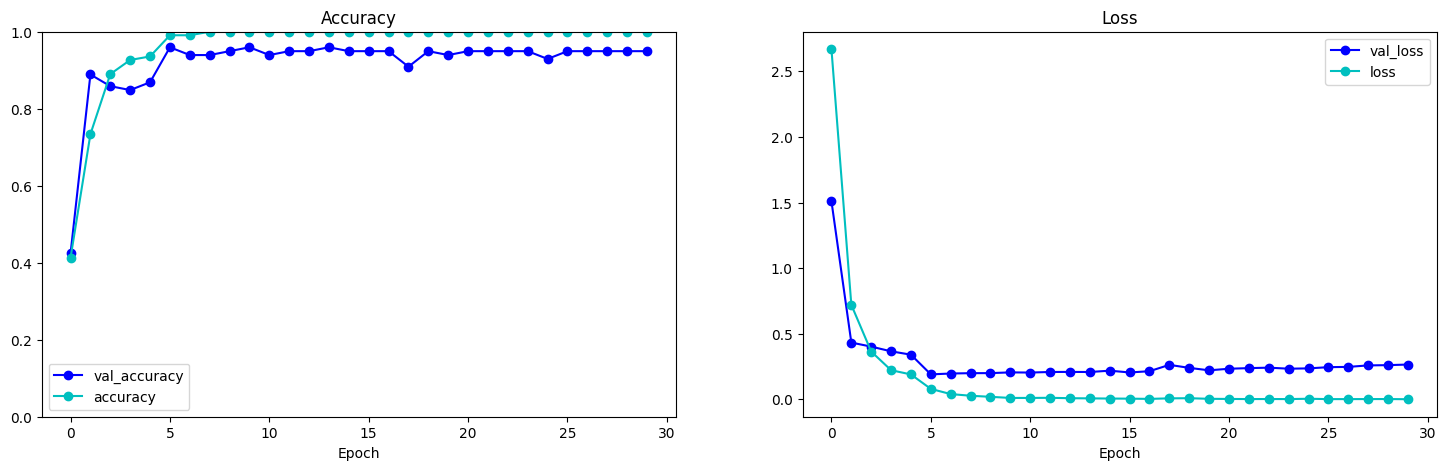

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
yhat = q_model.predict(X_test_tensor)
yhat = yhat.argmax(axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [36]:
print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in yhat:", np.unique(yhat))

Unique classes in y_test: [0 1 2]
Unique classes in yhat: [0 1 2]


In [37]:
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.97      0.97      0.97        33
           2       0.96      0.96      0.96        24

    accuracy                           0.97        66
   macro avg       0.98      0.98      0.98        66
weighted avg       0.97      0.97      0.97        66



Confusion matrix, without normalization


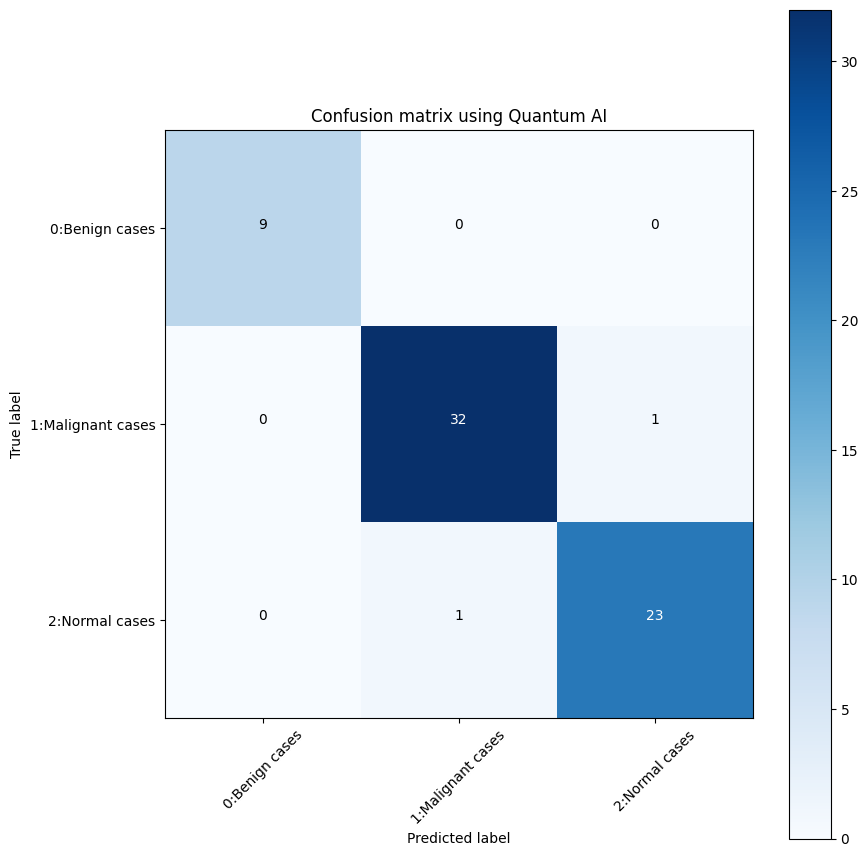

In [38]:
#3_Versuch # Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(9, 9))
plot_confusion_matrix(np.array(cnf_matrix[0:, 0:]), classes=['0:Benign cases', '1:Malignant cases','2:Normal cases'], normalize=False,  title='Confusion matrix using Quantum AI')

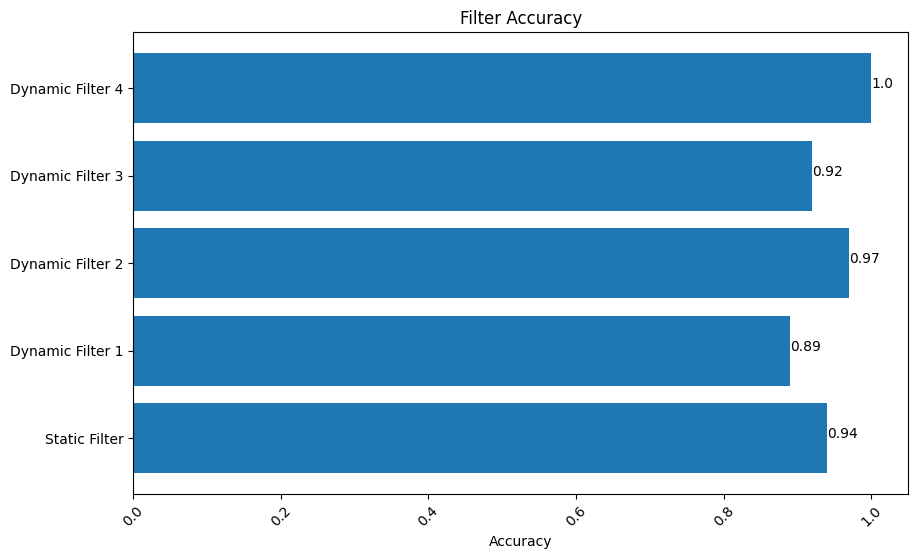

In [39]:
accuracy = [0.94,0.89,0.97,0.92,1.00]
Filter = ('Static Filter', 'Dynamic Filter 1', 'Dynamic Filter 2', 'Dynamic Filter 3', 'Dynamic Filter 4')

plt.figure(figsize=(10, 6))

plt.barh(Filter, accuracy)
for index, value in enumerate(accuracy):
	plt.text(value, index,
			str(value))
plt.title('Filter Accuracy')
plt.xlabel('Accuracy')
plt.xticks(rotation=45)
plt.show()
